In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from analysis.compare_disparities import NCC, MSE, SSIM
import subprocess
import cv2
import pandas as pd

In [3]:
metrics_dict = {
    "SSIM": SSIM,
    "MSE": MSE,
    "NCC": NCC
}

In [4]:
# compare metrics for different lambda for DP

def get_metrics_lambda(Dataset):
    Algo = "DP"
    data_folder = os.path.join("data", Dataset)
    img_gt_path = os.path.join(data_folder, "disp1.png")
    img_gt = cv2.imread(img_gt_path, cv2.IMREAD_GRAYSCALE)

    metrics = pd.DataFrame()

    for l in range(1, 22, 2):

        filename = f"output"
        if Algo == "DP": filename += f"_l{l}"
        filename += f"_w1_{Algo}.png"

        file_full_name = os.path.join("output", Algo, Dataset, filename)
        output_folder = os.path.join("output", Algo, Dataset)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        if not os.path.isfile(file_full_name):
            print(f"{file_full_name} does not exist. Computing disparity")
            process = subprocess.Popen(['./build/OpenCV_stereo',
                                            f'data/{Dataset}/view0.png', 
                                            f'data/{Dataset}/view1.png',
                                            f'output/{Algo}/{Dataset}/output',
                                            f'-l{l}', "-Htrue", "-ntrue", f"-m{Algo}"])
            stdout, stderr = process.communicate()
        image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
        for metric_name, metric in metrics_dict.items():
            metrics.loc[l, metric_name] = metric(image+200, img_gt)
    return metrics


In [5]:
Dataset = "Art"
metrics = get_metrics_lambda(Dataset)

Text(0.5, 1.0, 'Art')

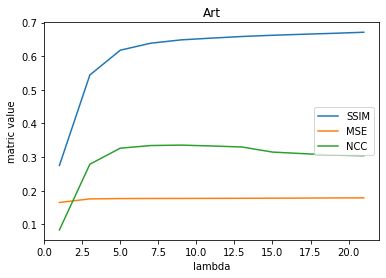

In [6]:
ax = metrics.plot()
ax.set_xlabel("lambda")
ax.set_ylabel("matric value")
ax.set_title(Dataset)

In [7]:
# compare methods

methods = ["DP", "naive"]

metrics = pd.DataFrame()

for Algo in methods:
    l = 9
    data_folder = os.path.join("data", Dataset)
    img_gt_path = os.path.join(data_folder, "disp1.png")
    img_gt = cv2.imread(img_gt_path, cv2.IMREAD_GRAYSCALE)

    filename = f"output"
    if Algo == "DP": filename += f"_l{l}"
    filename += f"_w1_{Algo}.png"

    w = 1 if Algo == "DP" else 9

    file_full_name = os.path.join("output", Algo, Dataset, filename)
    output_folder = os.path.join("output", Algo, Dataset)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    if not os.path.isfile(file_full_name):
        print(f"{file_full_name} does not exist. Computing disparity")
        process = subprocess.Popen(['./build/OpenCV_stereo',
                                        f'data/{Dataset}/view0.png', 
                                        f'data/{Dataset}/view1.png',
                                        f'output/{Algo}/{Dataset}/output',
                                        f'-l{l}', "-Htrue", "-ntrue", f"-m{Algo}", f"-w{w}"])
        stdout, stderr = process.communicate()
    image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
    for metric_name, metric in metrics_dict.items():
        metrics.loc[Algo, metric_name] = metric(image+200, img_gt)
        ()

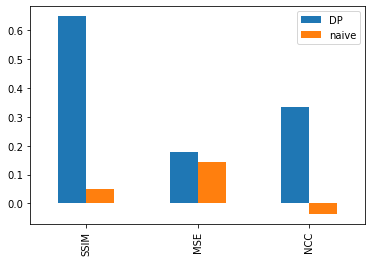

In [8]:
metrics.T.plot.bar()

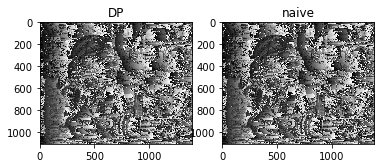

In [22]:
# diff images
methods = ["DP", "naive"]
f, ax = plt.subplots(1, len(methods))
for i, method in enumerate(methods):
    l = 9
    data_folder = os.path.join("data", Dataset)
    img_gt_path = os.path.join(data_folder, "disp1.png")
    img_gt = cv2.imread(img_gt_path, cv2.IMREAD_GRAYSCALE)

    filename = f"output"
    if Algo == "DP": filename += f"_l{l}"
    filename += f"_w1_{Algo}.png"

    w = 1 if Algo == "DP" else 9

    file_full_name = os.path.join("output", Algo, Dataset, filename)
    output_folder = os.path.join("output", Algo, Dataset)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    if not os.path.isfile(file_full_name):
        print(f"{file_full_name} does not exist. Computing disparity")
        process = subprocess.Popen(['./build/OpenCV_stereo',
                                        f'data/{Dataset}/view0.png', 
                                        f'data/{Dataset}/view1.png',
                                        f'output/{Algo}/{Dataset}/output',
                                        f'-l{l}', "-Htrue", "-ntrue", f"-m{Algo}", f"-w{w}"])
        stdout, stderr = process.communicate()
    image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
    image_diff = (image+200) - img_gt
    ax[i].imshow(image,cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(method)
plt.show()